## Pretrain single model

In [1]:
%load_ext autoreload
%autoreload 2


import sys; sys.path.append(2*'../')

import torch
import torch.nn as nn
from pathlib import Path
import wandb
from torchdyn.numerics import odeint
from tqdm.auto import tqdm

from math import pi as π

from kse527.systems.rendering.cartpole import CartPoleRendering
from kse527.control.cost import IntegralCost
from kse527.models.activations.snake import Snake
from kse527.tasks.default import DynamicSystemLearner
from notebooks.mpc.mpc import TorchMPC
from notebooks.mpc.utils_mpc import CartPole, CartpoleIntegralCost, BoxConstrainedController, RandConstController
from notebooks.mpc.utils import NeuralModelWrapper


## Hyperparameters

In [2]:
device = torch.device('cpu')

# Initial distribution of states and controller
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
u_min, u_max = -30, 30

# Build model via wrapper
# Here you can change activation functions, dimensions, activations, quantization etc
hdim = 32
inner_nn = nn.Sequential(nn.Linear(5, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
opt = torch.optim.Adam(inner_nn.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[5000, 10000, 15000], gamma=0.5)# dont use for few epochs. 20000 seem to be ok
model_nn = NeuralModelWrapper(inner_nn, RandConstController())


# Hyperparams
loss_func = nn.MSELoss()
epochs = 20000
bs = 128
dt = 0.02
span = torch.linspace(0, dt, 2)
losses = []

# Nominal system
sys_nominal = CartPole(u=RandConstController())

## Main training loop

Each epoch we sample from a distribution of controllers and states

This makes the learned model more robust since it basically learns any possible combination of states and controllers

--> Control is easier with this type of training

In [3]:
from tqdm.auto import trange
with trange(0, epochs, desc="Epochs") as stepx:
    for i in stepx:    
        x0 = init_dist.sample((bs,)).to(device)
        val = torch.Tensor(bs, 1).uniform_(u_min, u_max).to(device)
        model_nn.u.u0 = val
        sys_nominal.u.u0 = val
        
        # Compute loss
        _, sol_gt = odeint(sys_nominal.dynamics, x0, span, solver='rk4')[-1] # nominal: real system
        sol_model = model_nn.step(0, x0) # our model 
        loss = loss_func(sol_gt, sol_model)

        # Optimization step
        loss.backward(); opt.step(); opt.zero_grad(); scheduler.step()
        stepx.set_postfix({'Loss':loss})
        # print(f'Step: {i}, Residual loss: {loss:.8f}', end='\r')
        losses.append(loss.detach().cpu().item())

Epochs:   0%|          | 0/20000 [00:00<?, ?it/s]

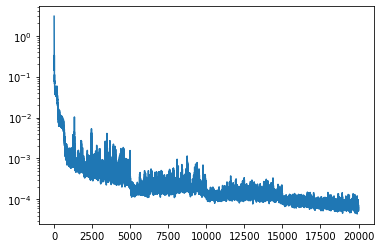

In [4]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.yscale('log')

In [92]:
# Save model
from pathlib import Path
path = Path('saved_models/')

torch.save(model_nn.model, path / 'model_example.pt')

## Quantization

In [17]:
from typing import Dict
from torch._C import dtype

DTYPE_BIT_SIZE: Dict[dtype, int] = {
    torch.float32: 32,
    torch.float: 32,
    torch.float64: 64,
    torch.double: 64,
    torch.float16: 16,
    torch.half: 16,
    torch.bfloat16: 16,
    # torch.complex32: 32,
    torch.complex64: 64,
    torch.complex128: 128,
    torch.cdouble: 128,
    torch.uint8: 8,
    torch.int8: 8,
    torch.qint8: 8,
    torch.int16: 16,
    torch.short: 16,
    torch.int32: 32,
    torch.int: 32,
    torch.int64: 64,
    torch.long: 64,
    torch.bool: 1
}

In [64]:
from copy import deepcopy

_model_fp32 = deepcopy(model_nn.model)

model_fp16 = torch.quantization.quantize_dynamic(
    deepcopy(_model_fp32),  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.float16)  # the target dtype for quantized weights

model_int8 = torch.quantization.quantize_dynamic(
    deepcopy(_model_fp32),  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights


model_nn_fp32 = deepcopy(model_nn)
model_nn_fp16  = NeuralModelWrapper(model_fp16, RandConstController())
model_nn_int8  = NeuralModelWrapper(model_int8, RandConstController())


# Loss with no reduction
loss_func = nn.MSELoss(reduction='none')


### One-step errors

In [65]:
# Sampling
sample_size = 1000
x0 = init_dist.sample((sample_size,)).to(device)
val = torch.Tensor(sample_size, 1).uniform_(u_min, u_max).to(device)

# Controller to each model
model_nn_fp32.u.u0 = val
model_nn_fp16.u.u0 = val
model_nn_int8.u.u0 = val
sys_nominal.u.u0 = val

# Compute loss
_, sol_gt = odeint(sys_nominal.dynamics, x0, span, solver='rk4')[-1] # nominal: real system
sol_model_fp32 = model_nn_fp32.step(0, x0) # our model 
sol_model_fp16 = model_nn_fp16.step(0, x0) # our model 
sol_model_int8 = model_nn_int8.step(0, x0) # our model 

loss_fp32 = loss_func(sol_gt, sol_model_fp32)
loss_fp16 = loss_func(sol_gt, sol_model_fp16)
loss_int8 = loss_func(sol_gt, sol_model_int8)

In [66]:
print(loss_fp32.mean())
print(loss_fp16.mean())
print(loss_int8.mean())

tensor(5.4084e-05, grad_fn=<MeanBackward0>)
tensor(5.3925e-05, grad_fn=<MeanBackward0>)
tensor(0.0015)


### Error propagation

In [78]:
# Error propagation
span_rollout = torch.linspace(0, 1, int(1/dt)+1)
sample_size = 1000
x0 = init_dist.sample((sample_size,)).to(device)
val = torch.Tensor(sample_size, 1).uniform_(u_min/5, u_max/5).to(device)

# Controller to each model
model_nn_fp32.u.u0 = val
model_nn_fp16.u.u0 = val
model_nn_int8.u.u0 = val
sys_nominal.u.u0 = val

# Compute loss
sol_gt = odeint(sys_nominal.dynamics, x0, span_rollout, solver='rk4')[1] # nominal: real system
sol_model_fp32 = model_nn_fp32.forward(x0, span_rollout) # our model 
sol_model_fp16 = model_nn_fp16.forward(x0, span_rollout) # our model 
sol_model_int8 = model_nn_int8.forward(x0, span_rollout) # our model 

loss_fp32 = loss_func(sol_gt, sol_model_fp32)
loss_fp16 = loss_func(sol_gt, sol_model_fp16)
loss_int8 = loss_func(sol_gt, sol_model_int8)

In [79]:
print(loss_fp32.mean())
print(loss_fp16.mean())
print(loss_int8.mean())

tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.5183)


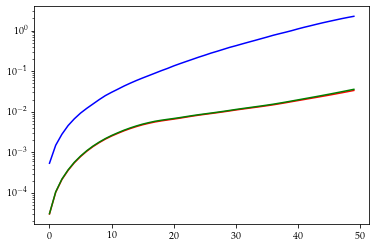

In [89]:
# Style
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "figure.facecolor": "white"
})

fig, ax = plt.subplots(1, 1)

# for i in range(len(loss_fp32)):
    # print(i)
ax.plot(loss_fp32[1:].detach().cpu().mean(dim=(1,2)), 'r')
ax.plot(loss_fp16[1:].detach().cpu().mean(dim=(1,2)), 'g')
ax.plot(loss_int8[1:].detach().cpu().mean(dim=(1,2)), 'b')
ax.set_yscale('log')

## Pruning


TODO: at least we should show this since we mention it

In [ ]:
# import torch.nn.utils.prune as prune


# _model_fp32 = deepcopy(model_nn.model)
# for name, param in _model_fp32.named_parameters():
#     print(param)
# prune.random_unstructured(_model_fp32, name="weight", amount=0.3)
